# Evaluation & Visualization of Experiments

iterations = 1,000  
trials = 3  
calibration_constraint = 0.1 （default）

In [1]:
import os
import json
from glob import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dpg_name = "dgp3_1000_3_01"
root_dir = f"/Users/s11616/Desktop/{dpg_name}"

In [3]:
# Parse json files.
rows = []
for exp_name in os.listdir(root_dir):
    jsonfile_paths = glob(os.path.join(root_dir, exp_name, '*.json'))
    
    for jsonfile_path in jsonfile_paths:
        
        jsonfile_name = jsonfile_path.split('/')[-1]
        if jsonfile_name == 'RobynModel-inputs.json':
            continue
        
        with open(jsonfile_path) as f:
            dic = json.load(f)
        
        for i, vals in enumerate(dic['ExportedModel']['summary']):
            if vals['variable'] in ['(Intercept)', 'trend', 'season', 'holiday'] :
                continue
            
            rows.append([exp_name, jsonfile_name, vals['variable'].split('_')[-1], vals['performance']])

In [4]:
df = pd.DataFrame(rows)
df.columns = ['EXP_NAME', 'FILENAME', 'MEDIA', 'PRED_ROI']

df['DPG'] = dpg_name

In [5]:
df_true = pd.read_csv(os.path.join(root_dir, os.listdir(root_dir)[0], 'true_roi.csv'))

In [9]:
_df_true = pd.DataFrame({'MEDIA': ['Facebook', 'TV'], 'TRUE_ROI': [float(x[0].split(': ')[1]) + 1 for x in df_true.values]})
df = pd.merge(df, _df_true, on='MEDIA')

In [11]:
df[['MEDIA', 'TRUE_ROI']].drop_duplicates()

,MEDIA,TRUE_ROI
0,Facebook,4.036197
41,TV,2.106916


In [12]:
def ape(pred, true):
    return abs((pred - true) / true)

In [13]:
df['APE_ROI'] = ape(df['PRED_ROI'], df['TRUE_ROI'])

In [14]:
cp = {'Facebook': sns.color_palette()[0], 'TV': sns.color_palette()[1]}

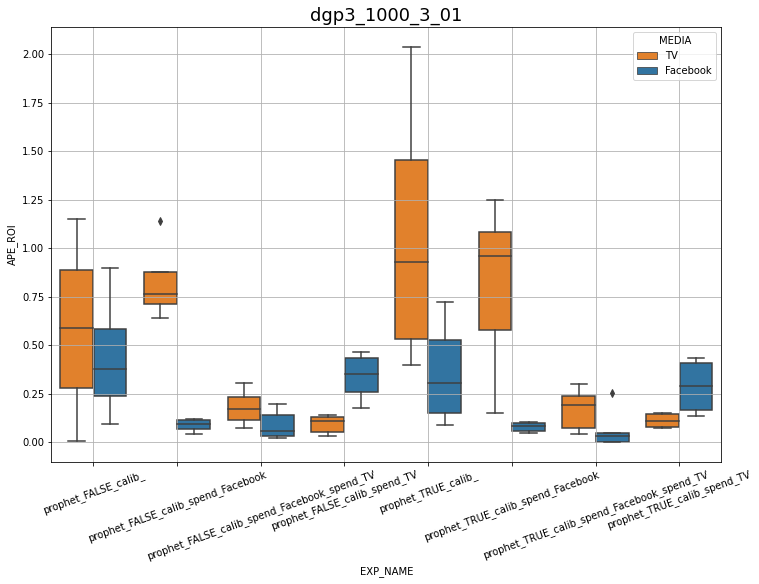

In [15]:
plt.figure(figsize=(12, 8))
sns.boxplot(x = "EXP_NAME", y = "APE_ROI", data = df.sort_values('EXP_NAME'), hue='MEDIA', palette=cp)
plt.title(dpg_name, fontsize=18)
plt.xticks(rotation=20)
plt.grid()

In [23]:
df.to_csv(f'csv/{dpg_name}.csv', index=False)

In [17]:
# Parse EXP_NAME.
df['USE_PROPHET'] = df['EXP_NAME'].apply(lambda x: x.split('_')[1] == "TRUE").astype(int)

df['CALIBRATION_FACEBOOK'] = df['EXP_NAME'].str.contains('Facebook').astype(int)
df['CALIBRATION_TV'] = df['EXP_NAME'].str.contains('TV').astype(int)
df['CALIBRATION_SEARCH'] = df['EXP_NAME'].str.contains('Search').astype(int)

In [18]:
def get_segmentname(row):
    cols = np.array(['Facebook', 'TV'])
    flag = np.array([row[f'CALIBRATION_{x.upper()}'] for x in cols])
    if sum(flag) == 0:
        return '0. None'
    else:
        x = sum(np.arange(1, 3) * flag) + int(sum(flag) == 2) + int(sum(flag) == 3)
        return f'{x}. ' + '_'.join(cols[np.where(flag == 1)])

In [19]:
df['SEGMENT_NAME'] = df.apply(lambda row: get_segmentname(row), axis=1)

In [20]:
df_agg_models = df.groupby(['EXP_NAME', 'USE_PROPHET', 'DPG', 'FILENAME', 'SEGMENT_NAME']).mean()['APE_ROI'].reset_index()

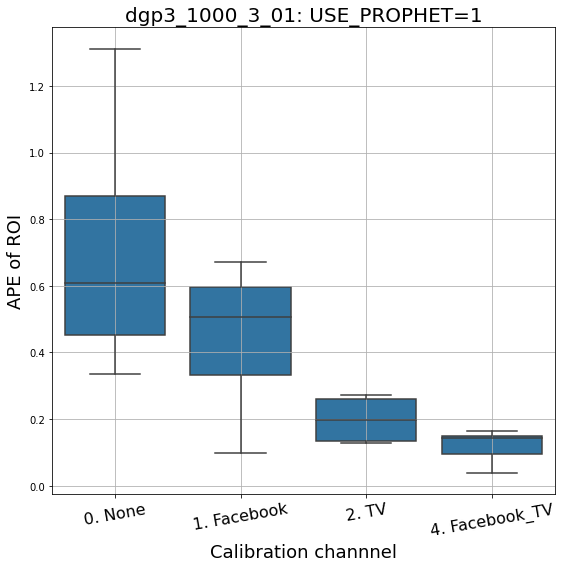

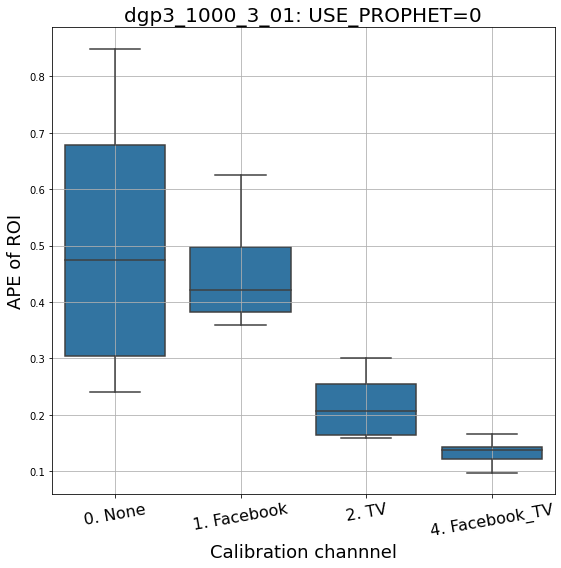

In [21]:
for use_prophet in [1, 0]:
    plt.figure(figsize=(8, 8))
    sns.boxplot(x = "SEGMENT_NAME", y = "APE_ROI", data = df_agg_models[df_agg_models['USE_PROPHET'] == use_prophet].sort_values('SEGMENT_NAME'), color=sns.color_palette()[0])
    plt.title(f'{dpg_name}: USE_PROPHET={use_prophet}', fontsize=20)
    plt.xticks(rotation=10, fontsize=16)
    plt.xlabel('Calibration channnel', fontsize=18)
    plt.ylabel('APE of ROI', fontsize=18)
    plt.grid()
    plt.tight_layout()

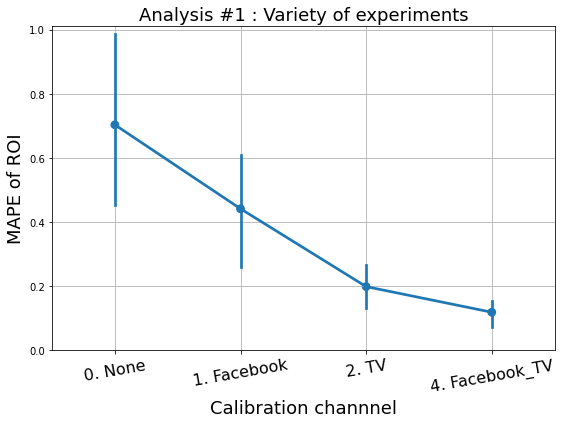

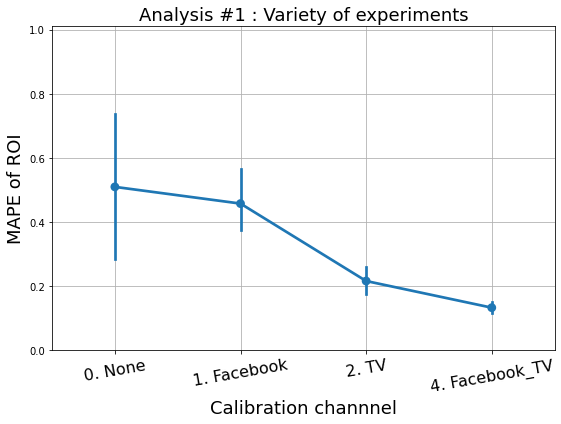

In [22]:
for use_prophet in [1, 0]:
    plt.figure(figsize=(8, 6))
    sns.pointplot(x='SEGMENT_NAME', y = 'APE_ROI', data = df_agg_models[df_agg_models['USE_PROPHET'] == use_prophet].sort_values('SEGMENT_NAME'), errorbar="ci")
    plt.title(f'Analysis #1 : Variety of experiments', fontsize=18)
    plt.ylim([0, 1.01])
    plt.xticks(rotation=10, fontsize=16)
    plt.xlabel('Calibration channnel', fontsize=18)
    plt.ylabel('MAPE of ROI', fontsize=18)
    plt.grid()
    plt.tight_layout()